# Phishing Email Classification using OpenAI fine-tuning

This notebook uses OpenAI fine-tuning to improve the performance of phishing email classification

## Dataset
Dataset preparation is done here: [data_preparation.ipynb](https://github.com/mikdrob/PhishingEmailMLModel/blob/main/jupiter/notebook/embeddings_create.ipynb)

## Required imports

In [65]:
import numpy as np
import pandas as pd
import openai
import os
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score
import seaborn
from sklearn.metrics import classification_report, f1_score

### Before execution add your OpenAI api key as environmental variable. Execute this in a new code block %env OPENAI_API_KEY={api_key}

In [56]:
!openai api fine_tunes.results -i ft-HmjjVjfQHtSomZT5TO9461VS > ../dataset/output/fine_tune_result.csv

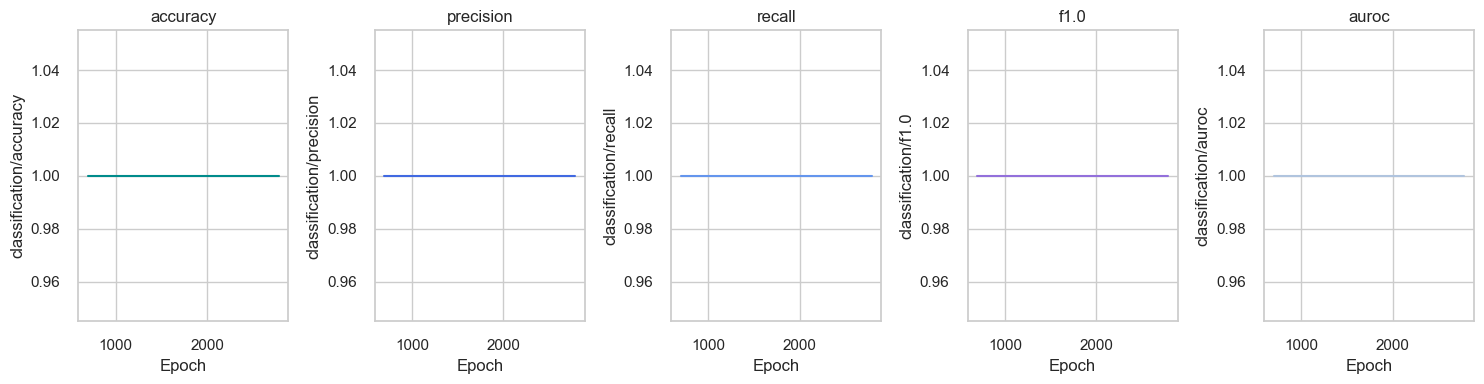

In [57]:
# read the results from the CSV file
results = pd.read_csv('../dataset/output/fine_tune_result.csv')

# create a list of metrics to plot
metrics = ['classification/accuracy', 'classification/precision', 'classification/recall', 'classification/f1.0', 'classification/auroc']

# set the style and color palette
seaborn.set(style='whitegrid')

colors = ['darkcyan', 'royalblue', 'cornflowerblue', 'mediumpurple', 'lightsteelblue']

# create subplots for each metric
fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=(15, 4))

# plot each metric
for i, metric in enumerate(metrics):
    if metric in results.columns:
        # remove NaN values and plot the metric
        data = results[metric].dropna()
        axes[i].plot(data, color=colors[i])
        # set the x and y labels
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(metric)
        # set the title of the plot
        title = metric.split('/')[1]
        axes[i].set_title(title)

# adjust the layout and display the plot
plt.tight_layout()
plt.show()



### Results report has shown 100% score in all metrics

## Model in action
### Model creation report has already shown the results. For demo run the test dateset is reduced to 50 records

In [58]:
test = pd.read_json('../dataset/input/emails_set_prepared_valid.jsonl', lines=True)

# Demo size for demonstration.
test = test.head(50)


In [59]:
openai.api_key = os.environ.get('OPENAI_API_KEY')

In [60]:
responses = []

## Newly created model name
ft_model = "ada:ft-personal:binary-email-classification-v2-2023-04-23-12-25-54"

## Iterate over the dataset and append results

In [61]:
for index, row in test.iterrows():
    response = {}
    try:
        start = True
        res = openai.Completion.create(model=ft_model,
                                       prompt=row.prompt + '\n\n###\n\n',
                                       max_tokens=1,
                                       temperature=0,
                                       logprobs=10)

        response["value"] = int(res['choices'][0]['text'])
        response["actual"] = row.completion
        response["probability_of_true"] = res['choices'][0]['logprobs']['top_logprobs'][0][" 1"]
        response["probability_of_false"] = res['choices'][0]['logprobs']['top_logprobs'][0][" 0"]
        responses.append(response)
    except Exception as e:
        pass

In [62]:
result = pd.DataFrame(responses)

In [67]:
actual = np.array(result['actual'])
predicted = np.array(result['value'])
probs = np.array(result['probability_of_true'])

## Model evaluation

In [68]:
# Evaluate the performance of the classifier using various metrics
report = classification_report(actual, predicted, digits=4)
accuracy = accuracy_score(actual, predicted)
f1 = f1_score(actual, predicted)
roc_auc = roc_auc_score(actual, probs)

print("Fine-tuned OpenAI Model Classification Report:\n", report)
print("Accuracy: {:.5f}".format(accuracy))
print("F1 Score: {:.5f}".format(f1))
print("ROC AUC Score: {:.5f}".format(roc_auc))

Fine-tuned OpenAI Model Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        39
           1     1.0000    1.0000    1.0000        10

    accuracy                         1.0000        49
   macro avg     1.0000    1.0000    1.0000        49
weighted avg     1.0000    1.0000    1.0000        49

Accuracy: 1.00000
F1 Score: 1.00000
ROC AUC Score: 1.00000


## Conclusion
The model was able to achieve an accuracy of 1.00 for all metrics. The model demonstrated the highest possible performance within this project's scope and limitations.